# <center><div style="font-family: Trebuchet MS; background-color: #AED6F2; color: #3498DB; padding: 12px; line-height: 1;">Cell2Cell Duke University Telco Dataset Analysis</div></center>

#### <center> Kwok Sze Ming [22022177D]</center>
- Dataset Link: https://www.kaggle.com/datasets/geoamins/cell2cell-duke-university-telco-dataset


<center>
    <img src="https://media.licdn.com/dms/image/D4D12AQHehFjrFpLb-A/article-cover_image-shrink_720_1280/0/1692565495463?e=1717632000&v=beta&t=N1y1bjgVJB1of4dSQd67M0DIPHTPvM1tmkpg4mLUFgY" alt="Telco" width="50%">
</center>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("C:/Users/user/Desktop/0capstone/cell2cell_duke/cell2cell_duke.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_3656\3058419429.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:/Users/user/Desktop/0capstone/cell2cell_duke/cell2cell_duke.csv")


In [3]:
data.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


# Get the column names with missing values

In [4]:
data.dropna(subset=['Churn'], inplace=True)
columns_with_missing_values = data.columns[data.isna().any()].tolist()

print(columns_with_missing_values)

['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'ServiceArea', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2']


In [5]:
dff=data.copy()
data.dropna(axis=0, inplace=True)

In [6]:
train_df = data.copy()

## All missing values are removed. 
### train_df: 49752 rows, 58 columns

In [7]:
print('Train data:')
print('There are' , train_df.shape[0] , 'rows')
print('There are' , train_df.shape[1] , 'columns')
print('There is' , train_df.duplicated().sum() ,'duplicated')
print('=====================================================')
print('Number of Churn:')
print(train_df['Churn'].value_counts())

Train data:
There are 49752 rows
There are 58 columns
There is 0 duplicated
Number of Churn:
No     35507
Yes    14245
Name: Churn, dtype: int64


# Yes:1, No:0

In [8]:
# Define a dictionary to map values
mapping = {'Yes': 1, 'No': 0, 'Known':1, 'Unknown': 0}

# Apply mapping to all columns
train_df = train_df.replace(mapping)

# Detect outliers

In [9]:
from scipy import stats

columns_with_outliers = {}

# Iterate over each column in train_df
for column in train_df.columns:
    if train_df[column].dtype in [np.int64, np.float64]:
        # Calculate Z-scores for the numeric column
        z_scores = np.abs(stats.zscore(train_df[column]))

        # Set a threshold for the Z-score above which a data point is considered an outlier
        z_threshold = 3

        # Find the indices of outliers based on the Z-scores
        z_outlier_indices = np.where(z_scores > z_threshold)

        Q1 = train_df[column].quantile(0.25)
        Q3 = train_df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Find the indices of outliers based on the IQR
        iqr_outlier_indices = np.where((train_df[column] < (Q1 - 1.5 * IQR)) | (train_df[column] > (Q3 + 1.5 * IQR)))

        # Check if either Z-score or IQR method detected outliers
        if len(z_outlier_indices[0]) > 0 or len(iqr_outlier_indices[0]) > 0:
            total_outliers = len(z_outlier_indices[0]) + len(iqr_outlier_indices[0])
            columns_with_outliers[column] = total_outliers

# Sort the dictionary by the number of outliers in descending order
sorted_columns_with_outliers = dict(sorted(columns_with_outliers.items(), key=lambda item: item[1], reverse=True))

print("Columns with outliers and the number of outliers (sorted from large to small):")
for column, num_outliers in sorted_columns_with_outliers.items():
    print(column, ":", num_outliers)


Columns with outliers and the number of outliers (sorted from large to small):
PercChangeRevenues : 13834
ChildrenInHH : 12269
HandsetWebCapable : 9694
NewCellphoneUser : 9611
TruckOwner : 9472
OwnsComputer : 9384
RoamingCalls : 8917
RVOwner : 8266
CallWaitingCalls : 7978
PercChangeMinutes : 7749
CustomerCareCalls : 7407
HandsetRefurbished : 6900
NotNewCellphoneUser : 6875
OverageMinutes : 6676
DirectorAssistedCalls : 6185
BlockedCalls : 6175
InboundCalls : 5787
NonUSTravel : 5712
Handsets : 5418
ThreewayCalls : 5042
DroppedBlockedCalls : 4776
ReferralsMadeBySubscriber : 4652
ReceivedCalls : 4593
DroppedCalls : 4576
OffPeakCallsInOut : 4530
UnansweredCalls : 4476
OutboundCalls : 4198
MonthlyRevenue : 3766
PeakCallsInOut : 3667
MonthlyMinutes : 3406
RetentionCalls : 3242
MadeCallToRetentionTeam : 3242
HandsetModels : 2665
AdjustmentsToCreditRating : 2210
UniqueSubs : 2002
CurrentEquipmentDays : 1885
MonthsInService : 1794
RetentionOffersAccepted : 1720
OptOutMailings : 1492
OwnsMotorcyc

# Boxplots

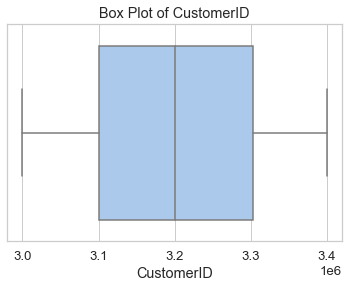

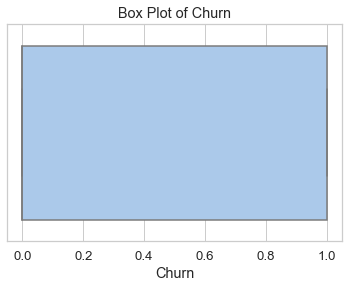

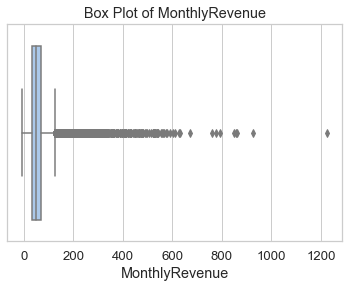

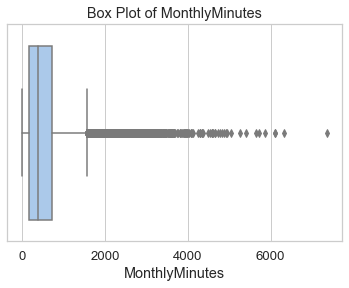

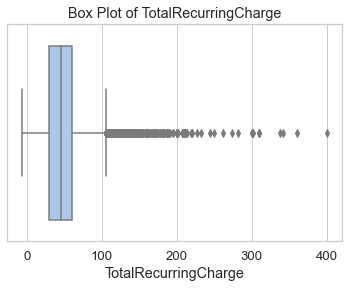

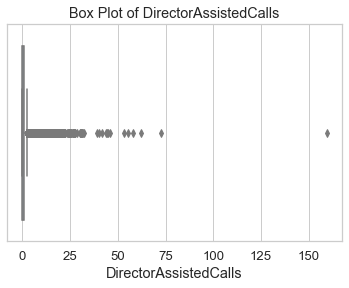

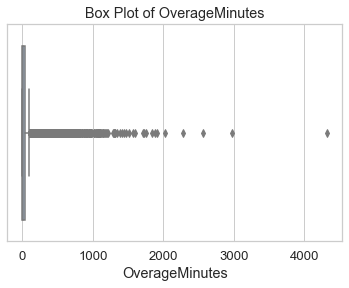

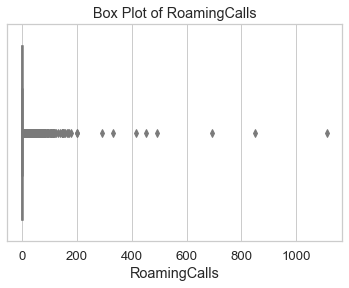

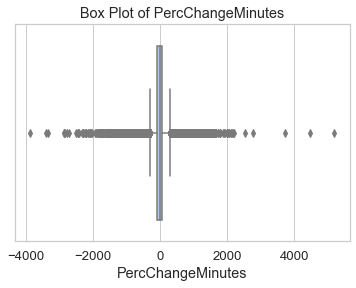

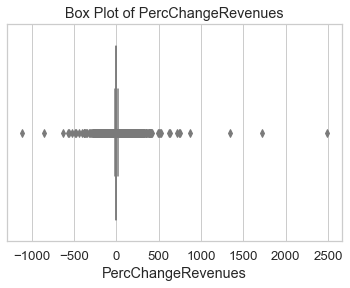

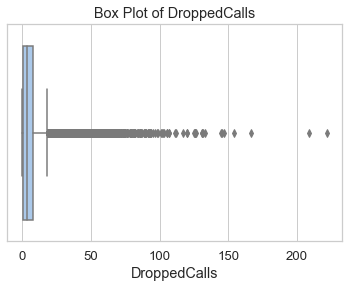

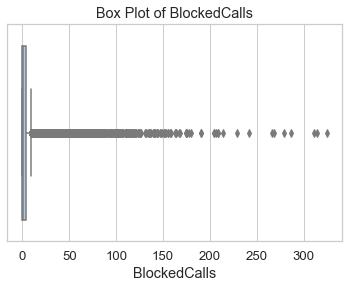

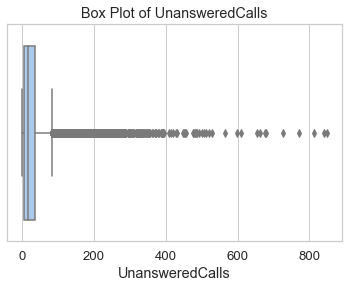

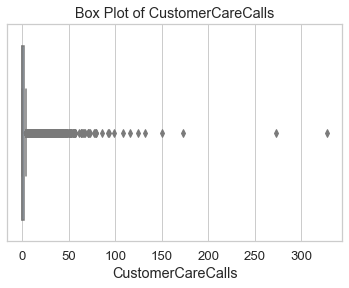

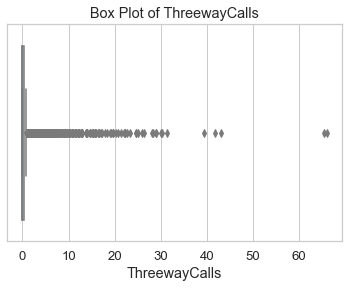

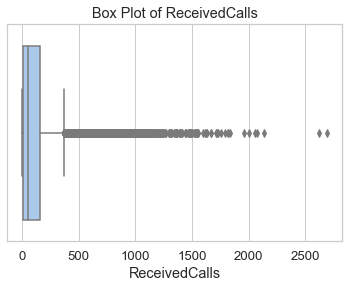

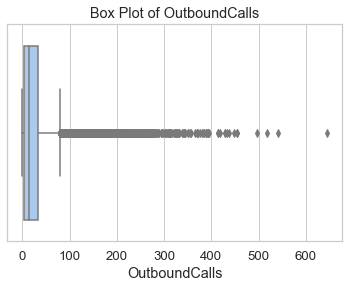

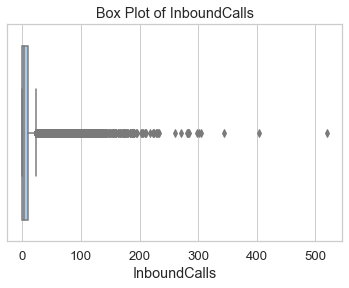

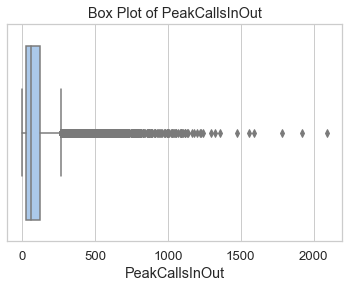

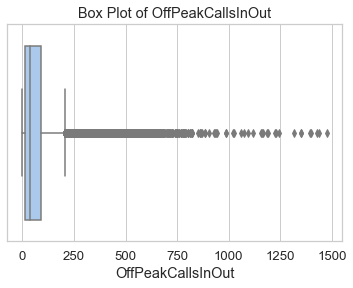

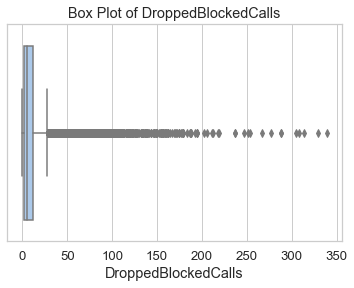

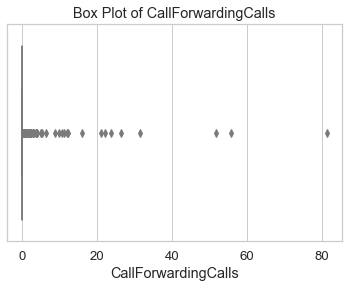

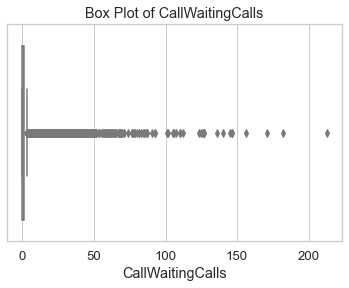

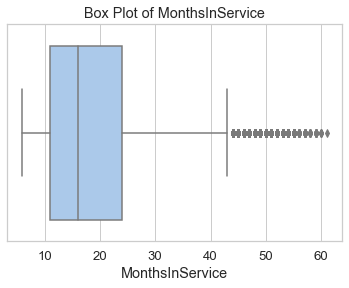

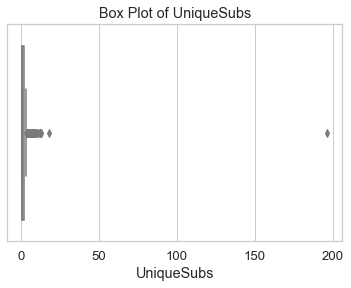

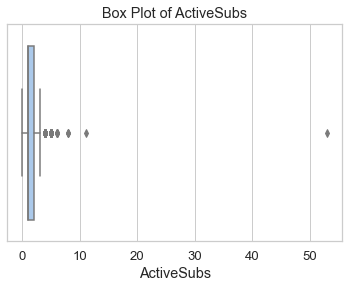

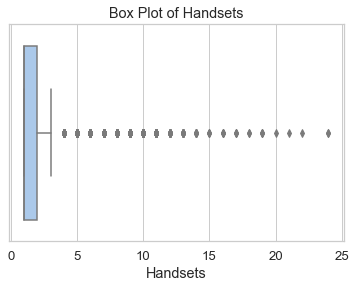

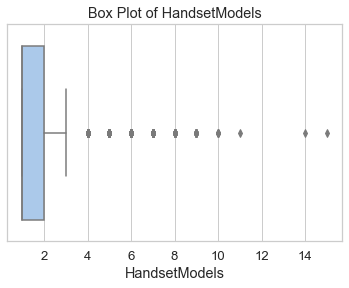

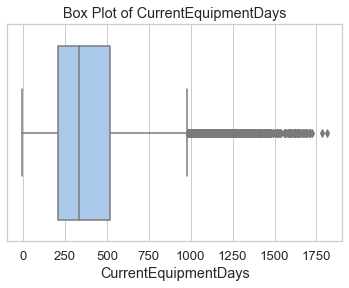

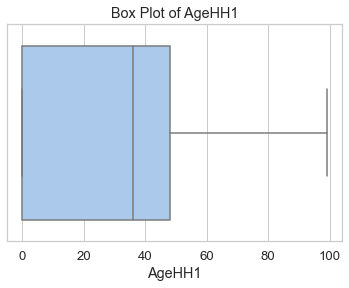

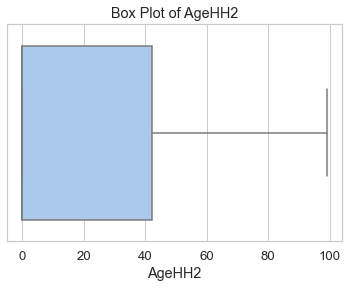

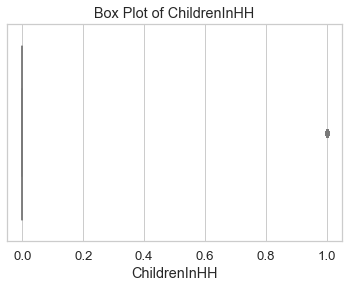

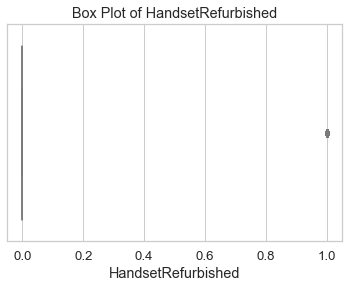

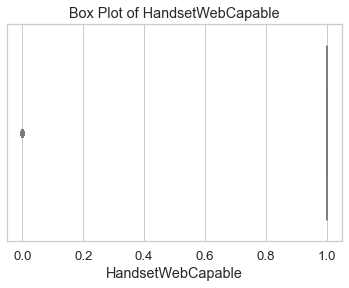

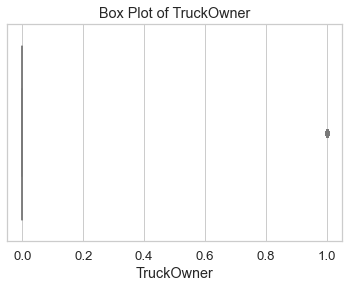

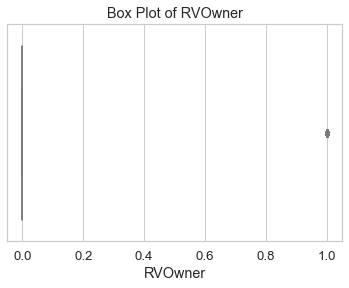

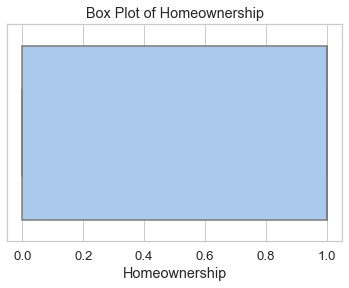

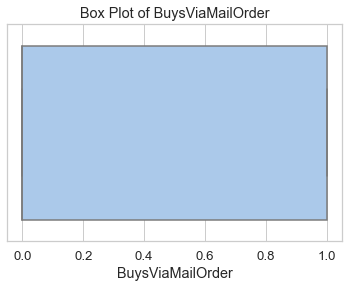

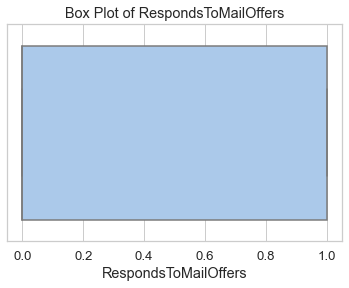

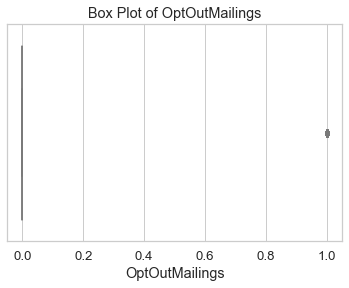

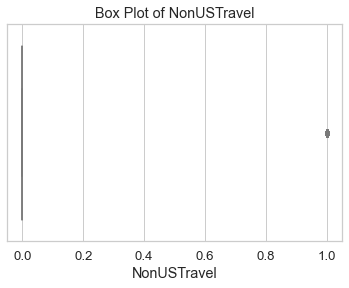

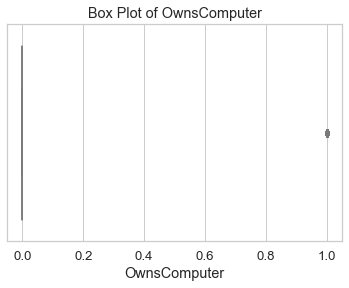

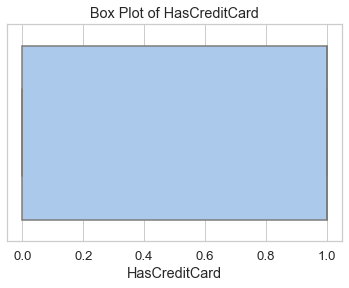

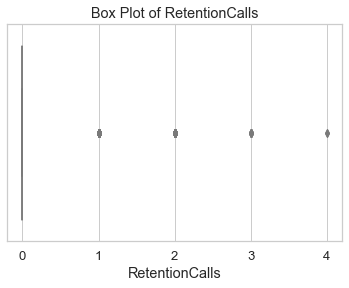

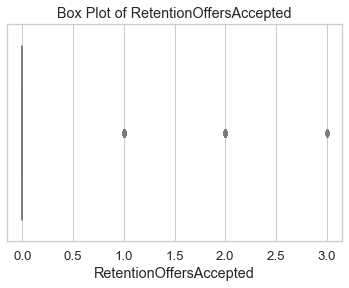

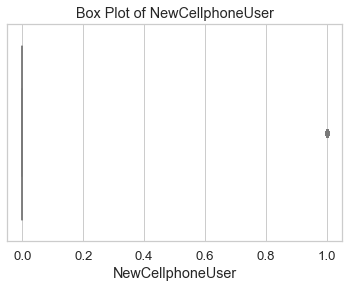

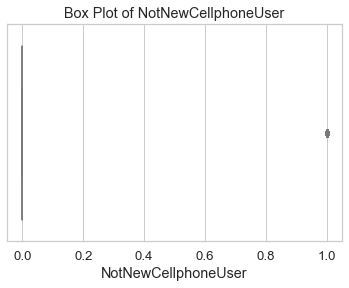

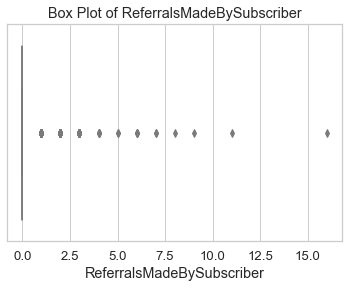

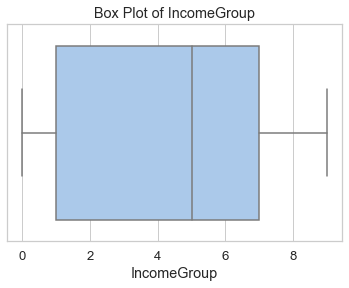

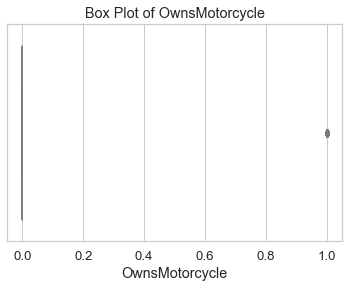

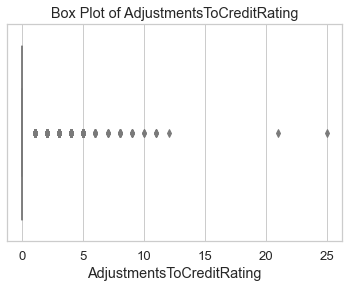

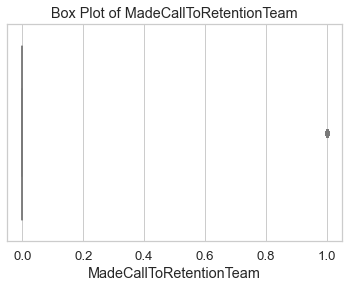

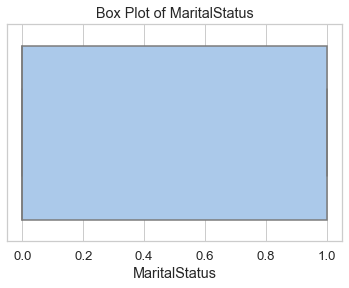

In [10]:
numeric_columns = train_df.select_dtypes(include=np.number).columns

summary_stats = train_df[numeric_columns].describe()

#Detect outliers using the interquartile range (IQR) method
q1 = summary_stats.loc['25%']
q3 = summary_stats.loc['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = (train_df[numeric_columns] < lower_bound) | (train_df[numeric_columns] > upper_bound)

# Identify columns with outliers
columns_with_outliers = outliers.any()

sns.set_palette("pastel")

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

for column in numeric_columns:
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(x=train_df[column], palette="pastel")
    ax.set_facecolor('white') 
    plt.title(f"Box Plot of {column}")
    plt.xlabel(column)
    plt.show()

# Heatmap

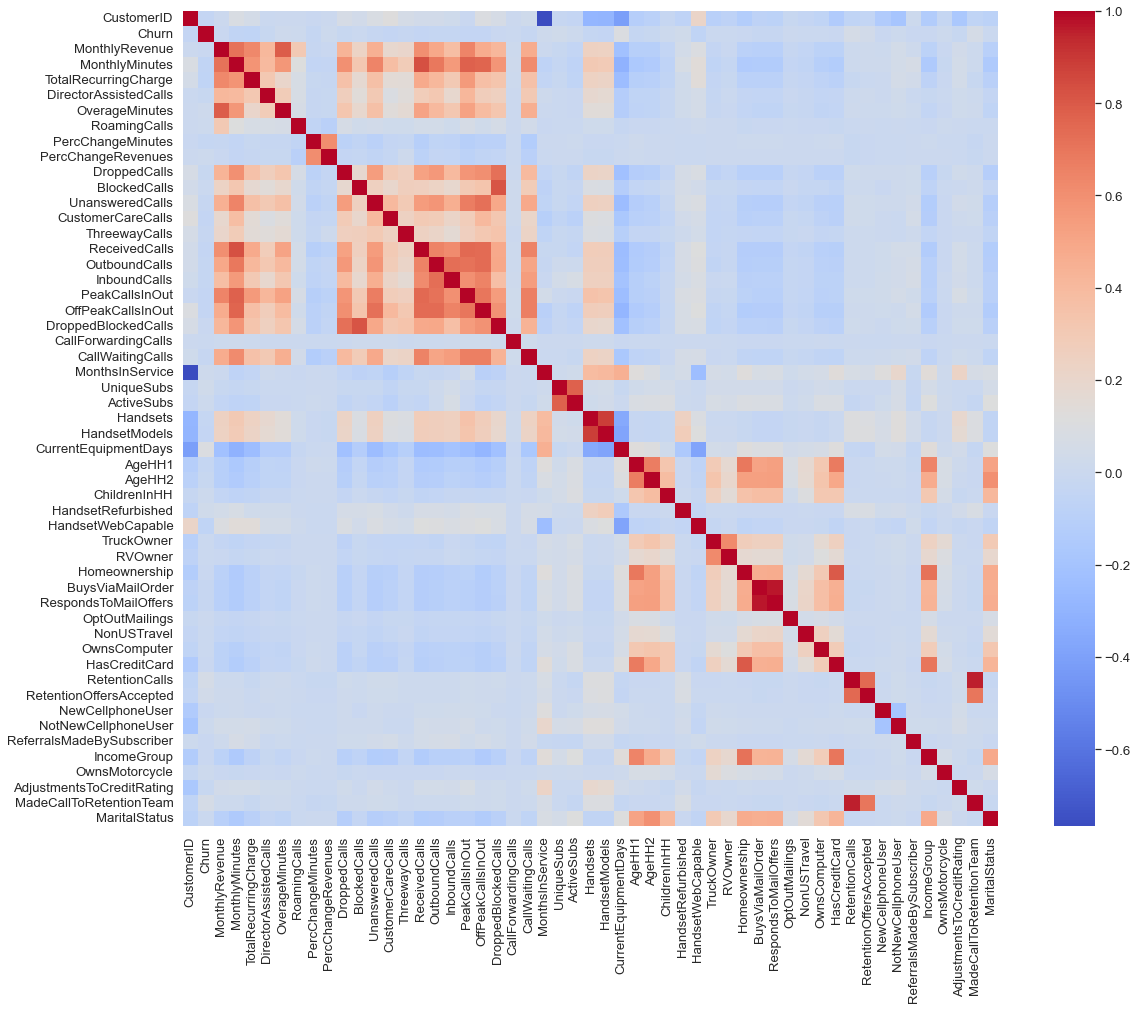

In [11]:
cor = train_df.corr()

plt.figure(figsize=(20, 15))

sns.heatmap(cor,square=True, cmap='coolwarm')

plt.show()

In [12]:
correlation = train_df.corr()['Churn']

# Sort the correlation values in descending order
correlation_sorted = correlation.sort_values(ascending=False)

negative_correlation_vars = correlation[correlation < 0].index

print(correlation_sorted)

Churn                        1.000000
CurrentEquipmentDays         0.102513
MadeCallToRetentionTeam      0.060577
RetentionCalls               0.058422
RetentionOffersAccepted      0.034511
UniqueSubs                   0.032839
HandsetRefurbished           0.030026
MonthsInService              0.017544
OverageMinutes               0.015301
ActiveSubs                   0.013049
PercChangeRevenues           0.013015
RoamingCalls                 0.010955
ChildrenInHH                 0.009505
OwnsMotorcycle               0.007700
NotNewCellphoneUser          0.006900
OptOutMailings               0.000880
OwnsComputer                -0.001231
NonUSTravel                 -0.002816
CallForwardingCalls         -0.003161
RVOwner                     -0.003280
BlockedCalls                -0.004474
MaritalStatus               -0.004567
TruckOwner                  -0.004873
NewCellphoneUser            -0.007639
HasCreditCard               -0.009204
ReferralsMadeBySubscriber   -0.011390
MonthlyReven

# Data Preprocessing

# Remove outliers

In [13]:
import pandas as pd

def remove_outliers_iqr(df, columns):
   
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# List of columns to consider for outlier removal
columns_to_check = sorted_columns_with_outliers

# Remove outliers using the IQR method
train_df_cleaned = remove_outliers_iqr(train_df, columns_to_check)

# Print the shape of the cleaned DataFrame to see how many outliers were removed
print("Original DataFrame shape:", train_df.shape)
print("Cleaned DataFrame shape:", train_df_cleaned.shape)


Original DataFrame shape: (49752, 58)
Cleaned DataFrame shape: (5155, 58)


In [14]:
# many unique number
train_df['ServiceArea'].value_counts()

NYCBRO917    1646
DALDAL214    1479
HOUHOU281    1471
NYCMAN917    1156
DALFTW817     771
             ... 
SANROM956       1
INDCRA765       1
SEWSUN509       1
ATLDBL478       1
NCRDNN910       1
Name: ServiceArea, Length: 743, dtype: int64

In [15]:
train_df_cleaned.drop(['ServiceArea', 'CustomerID'], axis=1, inplace=True)

In [16]:
train_df_cleaned['CreditRating']=train_df_cleaned['CreditRating'].replace({"1-Highest":1, "2-High":2, "3-Good":3, "4-Medium":4, 
                                                           "5-Low":5, "6-VeryLow":6, "7-Lowest":7})
train_df_cleaned['PrizmCode']=train_df_cleaned['PrizmCode'].replace({"Suburban":1, "Town":2, "Rural":3, "Other":4})

train_df_cleaned['HandsetPrice']=train_df_cleaned['HandsetPrice'].replace({"30":30, "10":10, "80":80, "150":150, "300":300, "40":40, "200":200, 
                                                           "100":100, "130":130, "60":60, "400":400, "240":240, "250":250, 
                                                           "180":180, "500":500})

train_df_cleaned['Occupation']=train_df_cleaned['Occupation'].replace({"Professional":1, "Crafts":2, "Self":3, "Clerical":4, 
                                                       "Homemaker":5, "Retired":6, "Student": 7, "Other":8})


In [17]:
trainn = train_df_cleaned.drop('Churn', axis=1)
churn = train_df_cleaned['Churn']

# Modeling

Model: LogisticRegression
Test Accuracy:
[[728  27]
 [259  17]]
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       755
           1       0.39      0.06      0.11       276

    accuracy                           0.72      1031
   macro avg       0.56      0.51      0.47      1031
weighted avg       0.64      0.72      0.64      1031


Model: DecisionTreeClassifier
Test Accuracy:
[[575 180]
 [178  98]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       755
           1       0.35      0.36      0.35       276

    accuracy                           0.65      1031
   macro avg       0.56      0.56      0.56      1031
weighted avg       0.65      0.65      0.65      1031


Model: RandomForestClassifier
Test Accuracy:
[[718  37]
 [229  47]]
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       755
           1       0.56      0.17  

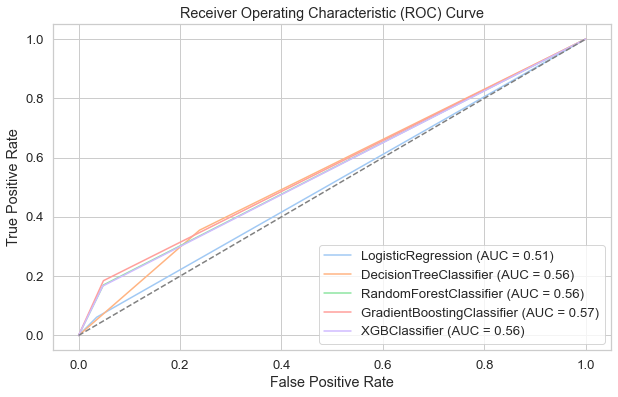

In [18]:
# Define a function to calculate Neyman-Pearson threshold
def calculate_np_threshold(probabilities, y_true, alpha):
    thresholds = np.linspace(0, 1, 100)  # Define a range of thresholds to search
    best_threshold = None
    best_tpr = 0
    for threshold in thresholds:
        y_pred = (probabilities > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tpr = tp / (tp + fn)  # True positive rate (TPR)
        fpr = fp / (fp + tn)  # False positive rate (FPR)
        if fpr <= alpha:  # Ensure type I error is bounded by alpha
            if tpr > best_tpr:
                best_tpr = tpr
                best_threshold = threshold
    return best_threshold

models = [
    LogisticRegression(random_state=15),
    DecisionTreeClassifier(random_state=15),
    RandomForestClassifier(n_estimators=300, criterion="gini", random_state=15, max_depth=100),
    GradientBoostingClassifier(random_state=15), 
    XGBClassifier(random_state=15)
]

model_names = []
accuracy_scores = []

X_train, X_test, y_train, y_test = train_test_split(trainn, churn, test_size=0.2, random_state=42)

scaler = StandardScaler()

plt.figure(figsize=(10, 6))
for model in models:
    model_names.append(model.__class__.__name__)

    Xs_train_scaled = scaler.fit_transform(X_train)
    Xs_test_scaled = scaler.transform(X_test)

    model.fit(Xs_train_scaled, y_train)

    # Predict probabilities
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(Xs_test_scaled)[:, 1]
    else:
        probabilities = model.decision_function(Xs_test_scaled)

    # Calculate Neyman-Pearson threshold
    alpha = 0.05  # specify the desired level of type I error
    threshold = calculate_np_threshold(probabilities, y_test, alpha)

    if threshold is None:
        # Handle the case when no suitable threshold is found
        threshold = 0.5

    # Make predictions based on the Neyman-Pearson threshold
    y_pred = (probabilities > threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    print(f"Model: {model.__class__.__name__}")
    print(f"Test Accuracy:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.legend(loc='lower right')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


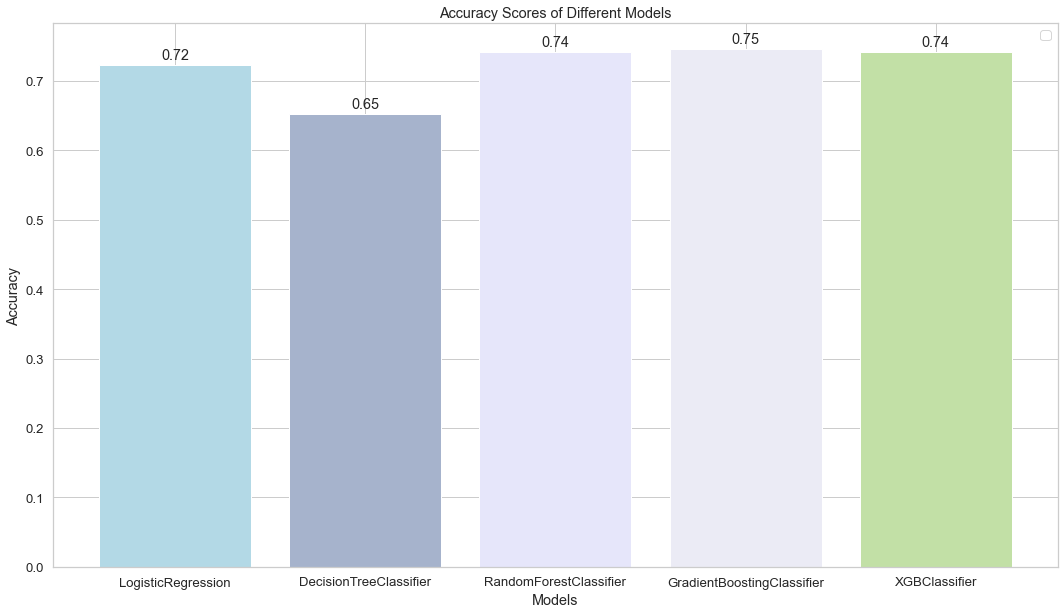

In [19]:
colors = ['#b3d9e6', '#a6b3cc', '#e6e6fa', '#ebebf5', '#c2e0a6']

plt.figure(figsize=(18, 10))
bars = plt.bar(model_names, accuracy_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores of Different Models')


for bar, accuracy in zip(bars, accuracy_scores):
    plt.annotate(f'{accuracy:.2f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')


overall_accuracy = accuracy_score(y_test, y_pred)
plt.legend()
plt.show()

# <center><div style="font-family: Trebuchet MS; background-color: #AEA6F1; color: #AED6F1; padding: 12px; line-height: 1;">Algorithm Results Table</div></center>
## <center><div style="font-family: Trebuchet MS; background-color: #89CFF0; color: #00008B; padding: 12px; line-height: 1;">Drop NaN(SMOTE)</div></center>

||ML Algorithm|F1 Score (Accuracy)|
|-|-|-|
|1|LogisticRegressionClassifier|65%|
|2|DecisionTreeClassifier|70%|
|3|RandomForestClassifier|81%|
|4|GradientBoostingClassifier|80%|
|5|XGBoostClassifier|82%|

## <center><div style="font-family: Trebuchet MS; background-color: #AEA6F1; color: #AED6F1; padding: 12px; line-height: 1;">END</div></center>